<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A5C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Target : 
# 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
# Less than or equal to 15 Epochs
# Less than 10000 Parameters

# Reorganize the network to increase depth after GAP so as to increase accuracy . Dropout settings need to be optimized.

# Result :
# Parameters: 12,754
# Best Train Accuracy: 98.53 (epoch 14)
# Best Test Accuracy: 99.43 (epoch 12)


# Analysis : Drop out settings were made consistent . This improved the training accuracy of the network 
#            Paramters have increased above the limitation of 10k parameters so this needs to be reduced as well

kernal	padding	stepsize 	nin	nout	rout	jout
0	0	0		0	28	1	1
3	0	1		28	26	3	1
3	0	1		26	24	5	1
3	1	1		24	24	7	1
2	0	2		24	12	8	1
3	0	1		12	10	12	2
3	0	1		10	8	16	2
3	1	1		8	8	20	2
3	0	1		8	6	24	2
6	0	6		6	1	30	2
3	1	1		1	1	48	12


In [0]:
# The gods
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


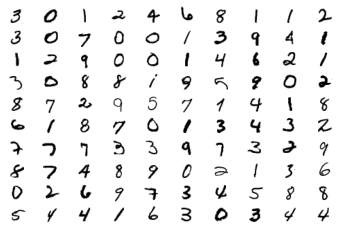

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
dropout = 0.09
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(8),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(8, 8, 3),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(8),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(8,16, 3,padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),

                                   nn.MaxPool2d(2, 2),

                                   nn.Conv2d(16, 16, 3),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(16, 16, 3),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(16, 16, 3, padding =1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(16, 16, 3),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.AvgPool2d(kernel_size=6),
                                   nn.Conv2d(16, 10, 3, padding=1))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
         Dropout2d-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]           1,168
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
        Dropout2d-12           [-1, 16, 24, 24]               0
        MaxPool2d-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.18881995975971222 Batch_id=468 Accuracy=77.85: 100%|██████████| 469/469 [00:10<00:00, 44.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0879, Accuracy: 9767/10000 (97.67%)

EPOCH: 1


Loss=0.12376084178686142 Batch_id=468 Accuracy=95.81: 100%|██████████| 469/469 [00:10<00:00, 43.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.1604713499546051 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:10<00:00, 43.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.054108113050460815 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:10<00:00, 42.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.1443171352148056 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:11<00:00, 42.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.1507139801979065 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:11<00:00, 42.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.06655754148960114 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:11<00:00, 42.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.12058552354574203 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:10<00:00, 42.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.032646432518959045 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:11<00:00, 42.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.012227430939674377 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.03919307515025139 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:11<00:00, 41.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.08871199935674667 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.03770736977458 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.05926499143242836 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:11<00:00, 40.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.05115446820855141 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 41.47it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

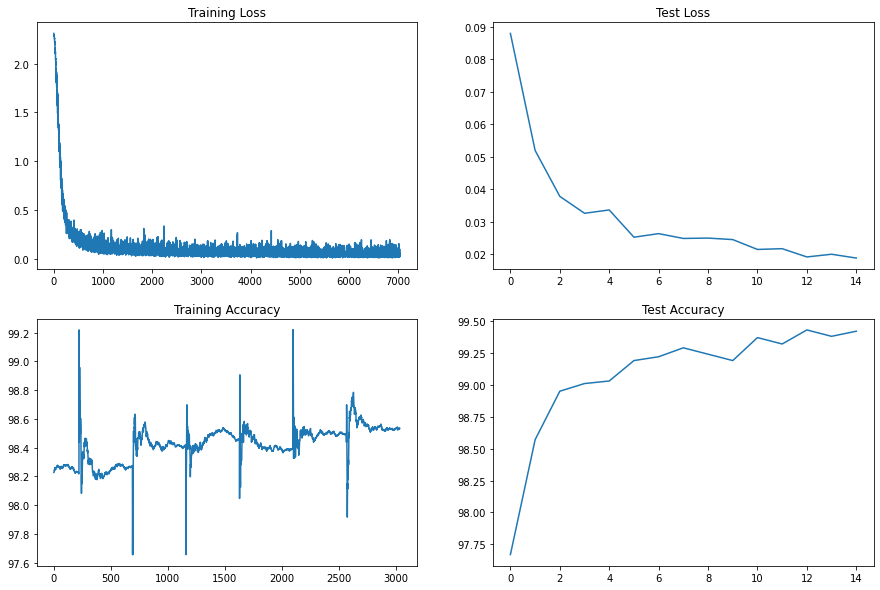

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")